In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

In [38]:
'''
1. Create a query or queries to extract the information you think may be relevant
for building the prediction model. It should include some film features and some rental features.
Use the data from 2005.
2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005).
This would be our target variable.
3. Read the data into a Pandas dataframe.
4. Analyze extracted features and transform them. You may need to encode some categorical variables,
or scale numerical variables.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

'''

'\n1. Create a query or queries to extract the information you think may be relevant\nfor building the prediction model. It should include some film features and some rental features.\nUse the data from 2005.\n2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005).\nThis would be our target variable.\n3. Read the data into a Pandas dataframe.\n4. Analyze extracted features and transform them. You may need to encode some categorical variables,\nor scale numerical variables.\n5. Create a logistic regression model to predict this variable from the cleaned data.\n6. Evaluate the results.\n\n'

In [35]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query1 = '''
select count(f.film_id), f.title, r.rental_date, 
f.rental_rate, r.return_date, i.inventory_id, f.length
from film f
join inventory i on i.film_id = f.film_id
join rental r on r.inventory_id = i.inventory_id
group by f.title order by r.rental_date desc;
'''
query2 = '''
select distinct f.title, case when
(
sum(
case
when date_format((r.rental_date), "%%m") = 5 and
date_format((r.rental_date), "%%Y") = 2005 then True
else False
end 
)
) >= 1 then 1 else 0 end as rented_in_may_2005
from film f
join inventory i on i.film_id = f.film_id
join rental r on r.inventory_id = i.inventory_id
group by f.title;
'''



In [36]:
data1 = pd.read_sql_query(query1, engine)
display(data1.head())
data1.shape

,count(f.film_id),title,rental_date,rental_rate,return_date,inventory_id,length
0,11,GATHERING CALENDAR,2005-08-02 22:34:06,0.99,2005-08-09 00:46:06,1610,176
1,4,TRAIN BUNCH,2005-08-02 22:18:24,4.99,2005-08-04 21:22:24,4161,71
2,11,TIES HUNGER,2005-08-02 22:18:13,4.99,2005-08-12 00:43:13,4077,111
3,12,LIBERTY MAGNIFICENT,2005-08-02 21:48:28,2.99,2005-08-05 23:58:28,2379,138
4,21,ARIZONA BANG,2005-08-02 21:36:46,2.99,2005-08-10 01:48:46,167,121


(958, 7)

In [37]:
data2 = pd.read_sql_query(query2, engine)
display(data2.head())
data2.shape

,title,rented_in_may_2005
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1


(958, 2)

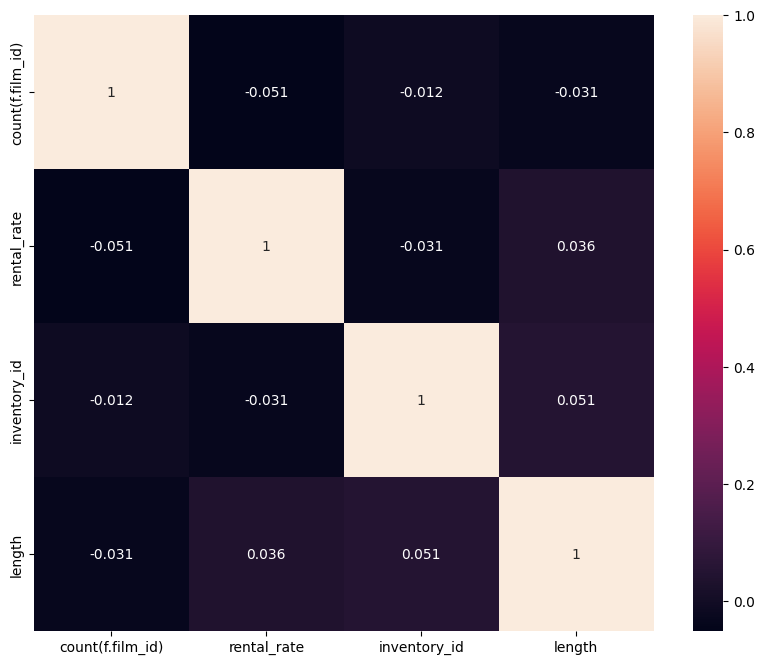

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
corr_matrix=data1.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [38]:
y = data2[["rented_in_may_2005"]]
X = data1
display(y.head(0))
display(X.head(0))

,rented_in_may_2005


,count(f.film_id),title,rental_date,rental_rate,return_date,inventory_id,length


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [40]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
X_train_num = X_train.select_dtypes(include = np.number)
# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [41]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,count(f.film_id),rental_rate,inventory_id,length
0,0.400000,0.0,0.185761,0.669065
1,0.466667,0.5,0.717853,0.460432
2,0.300000,0.0,0.613582,0.028777
3,0.366667,0.5,0.989266,0.669065
4,0.266667,0.0,0.820153,0.992806


In [48]:
# X_train_categorical = X_train.select_dtypes(include = np.object)
# X_train_cat = pd.get_dummies(X_train_categorical, 
#                              columns=['title'],
#                              drop_first=False)
# X_train_cat.head()

In [49]:
# X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [42]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_norm, y_train)

d:\Python 3.10\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [52]:
# # for categoricals
# X_test_categorical = X_test.select_dtypes(include = np.object)
# X_test_cat = pd.get_dummies(X_test_categorical, 
#                             columns=['title'],
#                             drop_first=False)
# # verify that dummies columns are in the same order and that the same column was dropped
# display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))
# # not needed if you treat each dataframe with one_hot_encoder and save the encode (and the column names)

# X_test_cat.head()

In [45]:
predictions = classification.predict(X_test_norm)
display(predictions)
classification.score(X_test_norm, y_test)

d:\Python 3.10\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

d:\Python 3.10\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.734375

In [71]:
# no to predict for june
query3 = '''
select count(f.film_id), f.title, r.rental_date, 
f.rental_rate, r.return_date, i.inventory_id, f.length
from film f
join inventory i on i.film_id = f.film_id
join rental r on r.inventory_id = i.inventory_id
group by f.title order by r.rental_date desc;
'''
query4 = '''
select distinct f.title, case when
(
sum(
case
when date_format((r.rental_date), "%%m") = 6 and
date_format((r.rental_date), "%%Y") = 2005 then True
else False
end 
)
) >= 1 then 1 else 0 end as rented_in_june_2005

from film f
join inventory i on i.film_id = f.film_id
join rental r on r.inventory_id = i.inventory_id
group by f.title;
'''

In [72]:
data3 = pd.read_sql_query(query3, engine)
display(data3.head())
data3.shape

,count(f.film_id),title,rental_date,rental_rate,return_date,inventory_id,length
0,11,GATHERING CALENDAR,2005-08-02 22:34:06,0.99,2005-08-09 00:46:06,1610,176
1,4,TRAIN BUNCH,2005-08-02 22:18:24,4.99,2005-08-04 21:22:24,4161,71
2,11,TIES HUNGER,2005-08-02 22:18:13,4.99,2005-08-12 00:43:13,4077,111
3,12,LIBERTY MAGNIFICENT,2005-08-02 21:48:28,2.99,2005-08-05 23:58:28,2379,138
4,21,ARIZONA BANG,2005-08-02 21:36:46,2.99,2005-08-10 01:48:46,167,121


(958, 7)

In [73]:
data4 = pd.read_sql_query(query4, engine)
display(data4.head())
data4.shape

,title,rented_in_june_2005
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1


(958, 2)

In [74]:
y_new = data4[["rented_in_june_2005"]]
X_new = data3
display(y_new.head())
display(X_new.head())
display(y_new.tail())
display(X_new.tail())

,rented_in_june_2005
0,1
1,0
2,1
3,1
4,1


,count(f.film_id),title,rental_date,rental_rate,return_date,inventory_id,length
0,11,GATHERING CALENDAR,2005-08-02 22:34:06,0.99,2005-08-09 00:46:06,1610,176
1,4,TRAIN BUNCH,2005-08-02 22:18:24,4.99,2005-08-04 21:22:24,4161,71
2,11,TIES HUNGER,2005-08-02 22:18:13,4.99,2005-08-12 00:43:13,4077,111
3,12,LIBERTY MAGNIFICENT,2005-08-02 21:48:28,2.99,2005-08-05 23:58:28,2379,138
4,21,ARIZONA BANG,2005-08-02 21:36:46,2.99,2005-08-10 01:48:46,167,121


,rented_in_june_2005
953,1
954,1
955,1
956,1
957,1


,count(f.film_id),title,rental_date,rental_rate,return_date,inventory_id,length
953,31,APACHE DIVINE,2005-05-25 01:59:46,4.99,2005-05-26 01:01:46,146,92
954,24,ROMAN PUNK,2005-05-25 01:10:47,0.99,2005-05-31 06:35:47,3376,81
955,26,PELICAN COMFORTS,2005-05-25 00:39:22,4.99,2005-06-03 03:30:22,3049,48
956,9,KING EVOLUTION,2005-05-25 00:22:55,4.99,2005-05-30 04:28:55,2294,184
957,10,MYSTIC TRUMAN,2005-05-24 23:08:07,0.99,2005-05-27 01:32:07,2792,92


In [75]:
# for numericals
X_new_num = X_new.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_new_normalized = transformer.transform(X_new_num)
X_new_norm = pd.DataFrame(X_new_normalized)

In [76]:
predictions_new = classification.predict(X_new_norm)
display(predictions_new)
classification.score(X_new_norm, y_new)

d:\Python 3.10\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

d:\Python 3.10\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.9394572025052192